In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import joblib
import os
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping


## Open master df

In [15]:
# Open master
df_train= pd.read_feather('../data/processed/train_data.feather')
df_test= pd.read_feather('../data/processed/test_data.feather')


# Modelling

Steps
1. Encode the categories
2. Normalise
3. Split and train
4. train 
5. Eval

### Preprocess data

In [16]:
# Features to process
boolean_cols = ["isNonStop", "isRefundable", "isBasicEconomy"]
scale_cols = ["DepartureTimeHour", "date_diff_days", 'weekday'  ]


# Preprocess the features
def preprocess_drop(df):
    df = df.drop(["searchDate", "flightDate", "segmentsArrivalAirportCode"], axis=1)
    return df


# Label encode for airports
def process_airports(df):
    le = LabelEncoder()
    all_airports = sorted(set(df["startingAirport"]).union(df["destinationAirport"]))
    le.fit(all_airports)

    df["startingAirport"] = le.transform(df["startingAirport"])
    df["destinationAirport"] = le.transform(df["destinationAirport"])
    # Print dictionary of the label encoder for airports with original values and the encoded values
    print(dict(zip(le.classes_, le.transform(le.classes_))))
    return df, le


# Process boolean columns
def process_boolean(df, boolean_cols):
    df[boolean_cols] = df[boolean_cols].astype(int)
    return df


# Scale data
def process_scale(df, scale_cols):
    scaler = StandardScaler()
    print("scale_cols", scale_cols)
    print("df[scale_cols]", df.columns)
    df[scale_cols] = scaler.fit_transform(df[scale_cols])
    return df, scaler


# Process test data
def process_test_data(df, le, scaler, boolean_cols, scale_cols):
    print("le", le)
    df["startingAirport"] = le.transform(df["startingAirport"])
    df["destinationAirport"] = le.transform(df["destinationAirport"])

    df = process_boolean(df, boolean_cols)
    print("processboolean", df.columns)
    df[scale_cols] = scaler.transform(df[scale_cols])
    return df



In [17]:
# Process the data into train, val, and test
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)

# Drop the columns that are not needed
train = preprocess_drop(df_train.copy())
val = preprocess_drop(df_val.copy())
test = preprocess_drop(df_test.copy())

In [18]:
# Process training data into the right labels and data types
df_train, le_airports = process_airports(train)
df_train = process_boolean(df_train, boolean_cols)
df_train, scaler = process_scale(df_train, scale_cols)


# Process test data
df_test = process_test_data(test, le_airports, scaler,  boolean_cols, scale_cols)


{'ATL': 0, 'BOS': 1, 'CLT': 2, 'DEN': 3, 'DFW': 4, 'DTW': 5, 'EWR': 6, 'IAD': 7, 'JFK': 8, 'LAX': 9, 'LGA': 10, 'MIA': 11, 'OAK': 12, 'ORD': 13, 'PHL': 14, 'SFO': 15}
scale_cols ['DepartureTimeHour', 'date_diff_days', 'weekday']
df[scale_cols] Index(['startingAirport', 'destinationAirport', 'isNonStop', 'isRefundable',
       'isBasicEconomy', 'totalFare', 'totalTravelDistance',
       'DepartureTimeHour', 'CabinCode', 'AirlineNameScore', 'date_diff_days',
       'weekday'],
      dtype='object')
le LabelEncoder()
processboolean Index(['startingAirport', 'destinationAirport', 'isNonStop', 'isRefundable',
       'isBasicEconomy', 'totalFare', 'totalTravelDistance',
       'DepartureTimeHour', 'CabinCode', 'AirlineNameScore', 'date_diff_days',
       'weekday'],
      dtype='object')


In [19]:
# Create tensorflow nn
def create_nn():
    # Define the input layers
    input_layers = []
    output_layers = []
    for col in categoy_features:
        input_layer = Input(shape=(1,), name=col)
        embedding = Embedding(input_dim=int(df_train[col].max()) + 1, output_dim=10)(input_layer)
        embedding = Flatten()(embedding)
        input_layers.append(input_layer)
        output_layers.append(embedding)
    for col in numerique_features:
        input_layer = Input(shape=(1,), name=col)
        input_layers.append(input_layer)
        output_layers.append(input_layer)
    # Concatenate the layers
    x = Concatenate()(output_layers)
    x = Dense(192, activation='relu')(x)
    x = Dense(288, activation='relu')(x)
    x = Dense(192, activation='relu')(x)
    x = Dense(1)(x)
    model = Model(inputs=input_layers, outputs=x)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

In [20]:
# Features to use
categoy_features = ['startingAirport', 'destinationAirport', 'AirlineNameScore', 'CabinCode', ]
numerique_features = [ 'weekday' ,'date_diff_days',  'isNonStop' ,'isRefundable', 'isBasicEconomy', 'DepartureTimeHour']
# 

input_dict={
    'startingAirport': df_train['startingAirport'],
    'destinationAirport': df_train['destinationAirport'],
    'AirlineNameScore': df_train['AirlineNameScore'],
    'CabinCode': df_train['CabinCode'],
    'DepartureTimeHour': df_train['DepartureTimeHour'],
    'date_diff_days': df_train['date_diff_days'],
    'weekday': df_train['weekday'],
    'isNonStop': df_train['isNonStop'],
    'isRefundable': df_train['isRefundable'],
    'isBasicEconomy': df_train['isBasicEconomy']

}

model = create_nn()
# Train the model with early stopping
history = model.fit(
    input_dict, 
    df_train['totalFare'], 
    epochs=25,  # Set a high number of epochs
    batch_size=64, 
    validation_split=0.2, 
    callbacks=[early_stopping]  # Include the EarlyStopping callback
)

# Evaluate the model
# predict
input_dict_test={
    'startingAirport': df_test['startingAirport'],
    'destinationAirport': df_test['destinationAirport'],
    'AirlineNameScore': df_test['AirlineNameScore'],
    'CabinCode': df_test['CabinCode'],
    'DepartureTimeHour': df_test['DepartureTimeHour'],
    'date_diff_days': df_test['date_diff_days'],
    'weekday': df_test['weekday'],
    'isNonStop': df_test['isNonStop'],
    'isRefundable': df_test['isRefundable'],
    'isBasicEconomy': df_test['isBasicEconomy']
}

y_pred = model.predict(input_dict_test)
mae = mean_absolute_error(df_test['totalFare'], y_pred)
rmse = root_mean_squared_error(df_test['totalFare'], y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')

# Save the model
model.save('../models/nns/nn_model3.keras')








2024-11-07 00:57:46.102712: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-07 00:57:46.401600: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/25


/home/raytechie/Projects/adv_mla_at3/ml_experimentation/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['startingAirport', 'destinationAirport', 'AirlineNameScore', 'CabinCode', 'weekday', 'date_diff_days', 'isNonStop', 'isRefundable', 'isBasicEconomy', 'DepartureTimeHour']. Received: the structure of inputs={'startingAirport': '*', 'destinationAirport': '*', 'AirlineNameScore': '*', 'CabinCode': '*', 'DepartureTimeHour': '*', 'date_diff_days': '*', 'weekday': '*', 'isNonStop': '*', 'isRefundable': '*', 'isBasicEconomy': '*'}
  warnings.warn(


59489/59489 ━━━━━━━━━━━━━━━━━━━━ 146s 2ms/step - loss: 20531.2676 - val_loss: 13618.5479
Epoch 2/25
59489/59489 ━━━━━━━━━━━━━━━━━━━━ 122s 2ms/step - loss: 13400.4746 - val_loss: 12837.8945
Epoch 3/25
59489/59489 ━━━━━━━━━━━━━━━━━━━━ 119s 2ms/step - loss: 12584.4541 - val_loss: 12372.1572
Epoch 4/25
59489/59489 ━━━━━━━━━━━━━━━━━━━━ 122s 2ms/step - loss: 12170.9863 - val_loss: 12077.5488
Epoch 5/25
59489/59489 ━━━━━━━━━━━━━━━━━━━━ 135s 2ms/step - loss: 12005.1182 - val_loss: 11727.8936
Epoch 6/25
59489/59489 ━━━━━━━━━━━━━━━━━━━━ 128s 2ms/step - loss: 11846.5371 - val_loss: 11623.1855
Epoch 7/25
59489/59489 ━━━━━━━━━━━━━━━━━━━━ 120s 2ms/step - loss: 11791.7949 - val_loss: 11700.3027
Epoch 8/25
59489/59489 ━━━━━━━━━━━━━━━━━━━━ 121s 2ms/step - loss: 11716.8857 - val_loss: 11425.3828
Epoch 9/25
59489/59489 ━━━━━━━━━━━━━━━━━━━━ 130s 2ms/step - loss: 11624.0215 - val_loss: 11535.1396
Epoch 10/25
59489/59489 ━━━━━━━━━━━━━━━━━━━━ 134s 2ms/step - loss: 11557.1211 - val_loss: 11431.0742
Epoch 11/2

/home/raytechie/Projects/adv_mla_at3/ml_experimentation/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['startingAirport', 'destinationAirport', 'AirlineNameScore', 'CabinCode', 'weekday', 'date_diff_days', 'isNonStop', 'isRefundable', 'isBasicEconomy', 'DepartureTimeHour']. Received: the structure of inputs={'startingAirport': '*', 'destinationAirport': '*', 'AirlineNameScore': '*', 'CabinCode': '*', 'DepartureTimeHour': '*', 'date_diff_days': '*', 'weekday': '*', 'isNonStop': '*', 'isRefundable': '*', 'isBasicEconomy': '*'}
  warnings.warn(


41312/41312 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step
Mean Absolute Error: 70.44334411621094
Root Mean Squared Error: 106.79190063476562


In [21]:
#  Save predictions for test data to a csv file
predictions_df = pd.DataFrame(y_pred, columns=['nn_predicted_totalFare'])
predictions_df.to_csv('../data/processed/predictions_nn.csv', index=False)


In [22]:
# Save the label encoders and scalers
joblib.dump(le_airports, '../models/nns/le_airports.joblib')
joblib.dump(scaler, '../models/nns/scaler.joblib')

['../models/nns/scaler.joblib']

### Plot the loss over Epoch

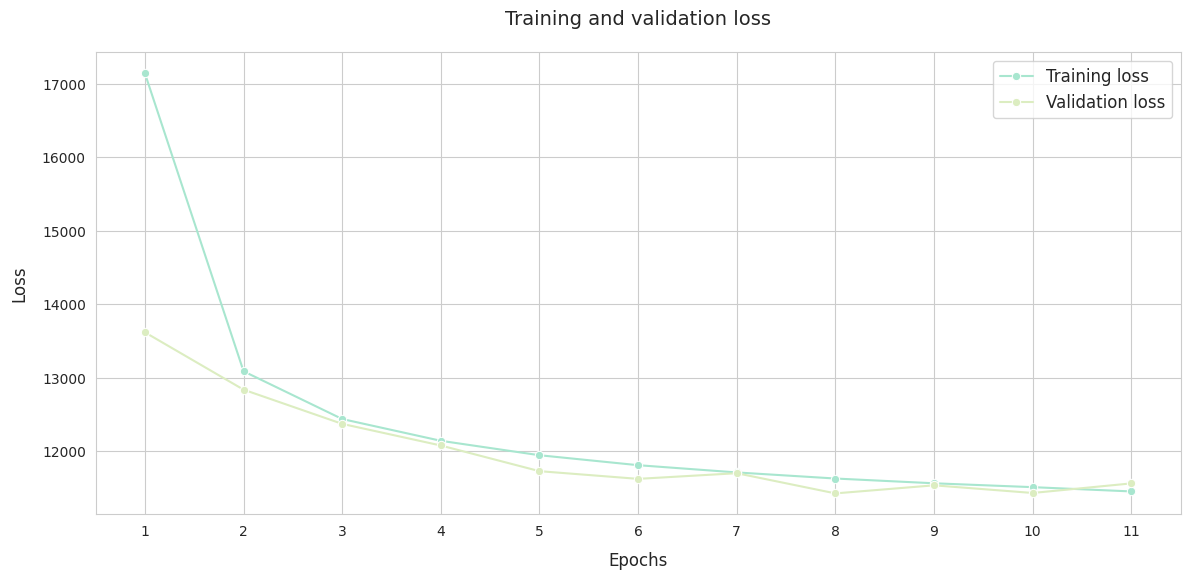

<Figure size 640x480 with 0 Axes>

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the loss
def set_custom_theme():
    sns.set_style('whitegrid')  # Set the style to whitegrid
    sns.set_palette(sns.color_palette(['#a8e6cf', '#dcedc1', '#ffd3b6', '#ffaaa5', '#ff8b94']))  # Set the custom palette
    # Manually set font sizes
    plt.rc('axes', titlesize=14)     # Font size for axes titles
    plt.rc('axes', labelsize=12)     # Font size for x and y labels
    plt.rc('xtick', labelsize=10)    # Font size for x tick labels
    plt.rc('ytick', labelsize=10)    # Font size for y tick labels
    plt.rc('legend', fontsize=12)    # Font size for legend
    plt.rc('font', size=12)          # General font size
    plt.figure(figsize=(14, 6))
# Apply the custom theme
set_custom_theme()


# Plot the training and validation loss using  sns.lineplot
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
sns.lineplot(x=epochs, y=loss, marker='o', label='Training loss')
sns.lineplot(x=epochs, y=val_loss, marker='o', label='Validation loss')
plt.title('Training and validation loss', pad=20)
plt.xlabel('Epochs',labelpad=10)
plt.ylabel('Loss',labelpad=10)
plt.xticks(epochs)
plt.legend()
plt.show()

# Save the plot
plt.savefig('../data/processed/nn_loss_plot.png')